In [1]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
import os

data_dir = 'data'
folder_path = f'{data_dir}/562Data V2 - Values.csv'
df = pd.read_csv(folder_path)

thumbnails_dir = f'{data_dir}/thumbnails-jpegs-v2'

cats = df['Category'].nunique()
print(cats)

# defines quartiles for each unique category
quartiles = df.groupby('Category')['View Count'].quantile([0.25, 0.5, 0.75]).unstack()

def assign_quartile(category, view_count):
    Q1 = quartiles.loc[category, 0.25]
    Q2 = quartiles.loc[category, 0.5]
    Q3 = quartiles.loc[category, 0.75]
    
    if view_count <= Q1:
        return 1
    elif view_count <= Q2:
        return 2
    elif view_count <= Q3:
        return 3
    else:
        return 4
 
X = []
y = []
titles = []
categories = []

    
for img in os.listdir(thumbnails_dir):
    img_path = os.path.join(thumbnails_dir, img)
    loc = df.loc[df['Id'] == img[:-4]] ## locates the matching ids for images and corresponding feature in csv
    if loc.empty:                      ## as some of our data has no matching ids, just skip and remove the data
        os.remove(img_path)
        
    else:
        if np.float32(np.asarray(loc['View Count'])[0]) > 0:
            thumb = load_img(img_path)
            thumb_256 = thumb.resize((256,256))         ## resize all images to 256 x 256, easier to work with in Conv2d
            X.append(thumb_256)                       ## append all images as arrays to X
            category = loc['Category'].iloc[0]           ## Extract single value from Series
            categories.append(category)  # append category
            titles.append(loc['Title'].iloc[0])  # append title
            y.append(assign_quartile(category, np.float32(np.asarray(loc['View Count'])[0])))  ## compute quartile & save
assert(len(y) == len(X))

19


In [3]:
text = clip.tokenize(titles).to(device) ## tokenize using clip

with torch.no_grad():                   ## encodes images and titles using clip, using lots of toList because clip outputs tensors
    encoded_images = [] 
    for images in X:
        features = model.encode_image(preprocess(images).unsqueeze(0).to(device)).tolist()
        encoded_images.append(features)
    
    encoded_texts = model.encode_text(text)


# One-hot encoding for categories
categories_one_hot = pd.get_dummies(categories)
categories_one_hot_array = categories_one_hot.values



In [4]:
image_features = []
for image in encoded_images:     ## creates list of 512 features per image
    flat_image = [x for xs in image for x in xs]
    image_features.append(flat_image)
    
np.array(image_features).shape  ## should be # of samples x 512 features

(3196, 512)

In [21]:

all_features = []
for i in range(len(image_features)):        ## append all features in single list: [512 image features, 512 text features, 19 category features]
    features_1043 = image_features[i] + encoded_texts[i].tolist()
    for cat in categories_one_hot_array[i]:
        features_1043.append(np.float32(cat))
    all_features.append(features_1043)

np.array(all_features).shape ## should be # of samples x 1043 features

(3196, 1043)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

clf = LogisticRegression(random_state=123, max_iter = 1000)

k_folds = KFold(n_splits = 5)

scores = cross_val_score(clf, all_features, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.4890625  0.49295775 0.49921753 0.48200313 0.52112676]
Average CV Score:  0.4968735328638497
Number of CV Scores used in Average:  5


In [41]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(n_estimators = 100, random_state=42, max_depth = 10, warm_start = True)

k_folds = KFold(n_splits = 5)

scores = cross_val_score(tree, all_features, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))
      



Cross Validation Scores:  [0.49375    0.5086072  0.47261346 0.45070423 0.51956182]
Average CV Score:  0.4890473395931142
Number of CV Scores used in Average:  5


Accuracy with max depth of 3 on test set:  0.4504692387904067


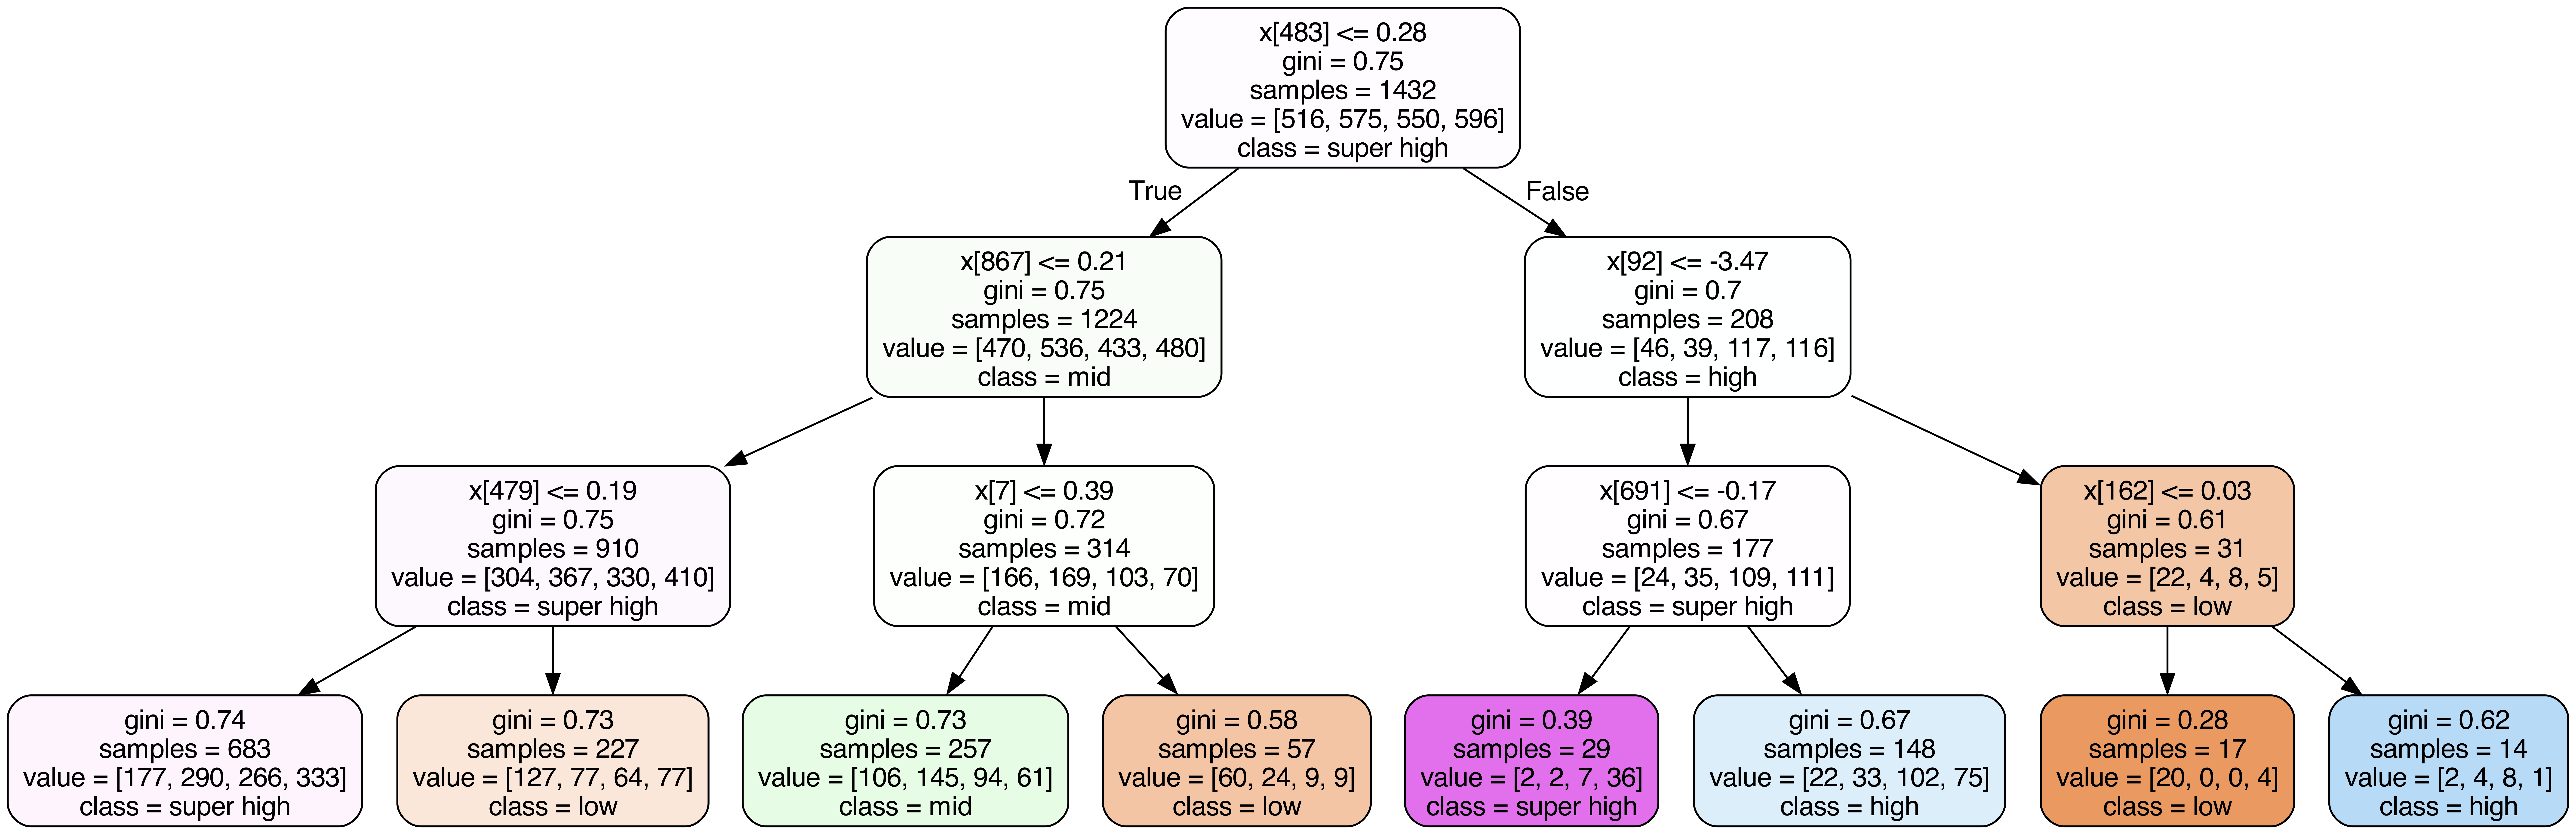

In [44]:
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size=0.30, random_state=42)

new_tree = RandomForestClassifier(n_estimators = 100, random_state=42, max_depth = 3, warm_start = True)

new_tree.fit(X_train, y_train)

y_pred = new_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy with max depth of 3 on test set: ", accuracy)
estimated_tree = new_tree.estimators_[5]

export_graphviz(estimated_tree, out_file='tree.dot',
                class_names = ['low', 'mid', 'high', 'super high'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
from IPython.display import display
img = Image(filename = 'tree.png')
display(img)